In [1]:
import matplotlib.pyplot as plt
from scipy.stats import entropy
import skmob
from skmob.measures.individual import real_entropy, uncorrelated_entropy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

formatter = ticker.FormatStrFormatter("%.2f")

In [ ]:
data = pd.read_csv("labeled_ads.csv", index_col=0)

In [3]:
top_labels = (data["top_label"].value_counts()).iloc[:19]  # all labels

# calcu the amount + % for each top
top_percentages = (data["top_label"].value_counts(normalize=True).iloc[:18]) * 100

# Print the counts and percentages in a readable format
print("Stats on top labels:\n")
for label, count, percentage in zip(
    top_labels.index, top_labels.values, top_percentages.values
):
    print(f"{label}: {count} ads ({percentage:.2f}%)")

Stats on top labels:

Call for Action: 353488 ads (76.89%)
Healthcare: 20754 ads (4.51%)
Law and Crime: 17701 ads (3.85%)
Economy: 10691 ads (2.33%)
Climate: 10426 ads (2.27%)
Immigration: 9408 ads (2.05%)
Defense: 8676 ads (1.89%)
Other: 6747 ads (1.47%)
Education and Culture: 5048 ads (1.10%)
Labor and Employment: 4585 ads (1.00%)
Foreign Affair: 4035 ads (0.88%)
Civil Rights: 3213 ads (0.70%)
Agriculture: 1555 ads (0.34%)
Housing: 1192 ads (0.26%)
Transport: 1135 ads (0.25%)
Social Welfare: 1074 ads (0.23%)


In [4]:
# the most 'heavy' ones to proces are Bernie Sanders 124955570892789 and Alexandria Ocasio-Cortez 1316372698453411
top_10_ids = data["page_id"].value_counts().head(10)
print(top_10_ids)

page_id
124955570892789     57326
1316372698453411    55604
38471053686         36480
163148530407080     16046
36872302227         15445
6820348410          12106
97493741436          9096
57495285387          7038
428821014132730      7001
165987503528599      6721
Name: count, dtype: int64


### Entropy code

In [ ]:
# Prep data
data = data[["page_id", "page_name", "top_label", "ad_creation_time"]]
data["top_label_int"] = (
    pd.factorize(data["top_label"], sort=True)[0] + 1
)  # convert Categories to float starting from 1.0 alphabetically
data["lat"] = 0.0  # replacing latitude (mandatory column, giving it a random value)

# Convert to Traj
tdf = skmob.TrajDataFrame(
    data,
    latitude="lat",
    longitude="top_label_int",
    datetime="ad_creation_time",
    user_id="page_id",
)

# Sort TrajDataFrame by user ID and datetime
tdf = tdf.sort_values(by=["uid", "datetime"])

# calculate uncor
ue_df = uncorrelated_entropy(tdf, normalize=False)
re_df = real_entropy(tdf)

In [ ]:
ue_df.to_csv("uncorrelated_entropy.csv", index=False, header=True)
re_df.to_csv("real_entropy.csv", index=False, header=True)

## Sort away duplicate values and merge uncorrelated values back into dataframe

In [ ]:
data_org = pd.read_csv("labeled_ads.csv", index_col=0)
data_un = data_org.drop_duplicates(subset=["page_id"]) # narrowing down to 518 politicians
data_un = pd.merge(data_un, ue_df, left_on="page_id", right_on="uid", how="left") # mapping uncorrealted values back to dataframe with 518 politicians
data_un = data_un.drop("uid", axis=1)
data_un = pd.merge(data_un, re_df, left_on="page_id", right_on="uid", how="left")
data_un = data_un.drop("uid", axis=1)

NameError: name 'ue_df' is not defined

## uncorrelated vs real entropy plots

In [113]:
# normalize values for uncor + real entropy 
values_uncor, bins = np.histogram(data_un["uncor entropy"], bins=np.linspace(0, 3.6, 19))
values_uncor = values_uncor / sum(values_uncor)
values_real, bins = np.histogram(data_un["real entropy"], bins=np.linspace(0, 3.6, 19))
values_real = values_real / sum(values_real)

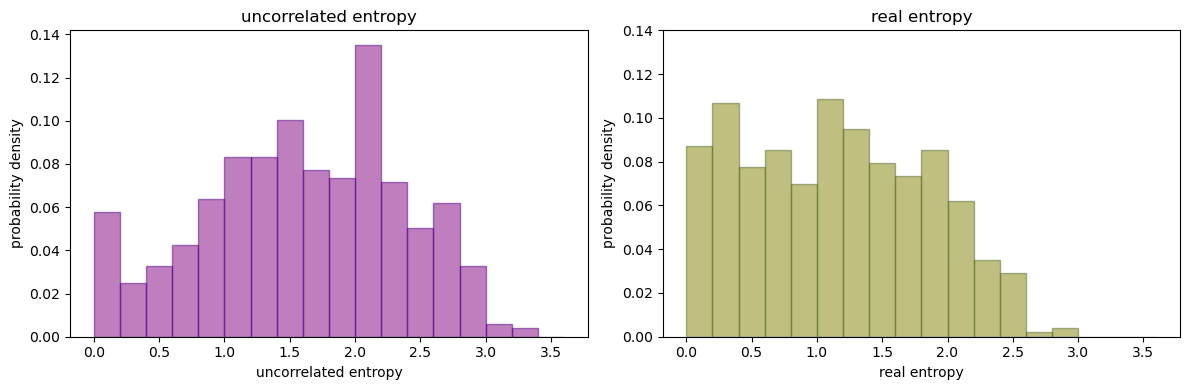

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_uncor,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="purple",
    edgecolor="indigo",
)
axes[0].set_title("uncorrelated entropy")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")

axes[1].bar(
    bins[:-1],
    values_real,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

max_y = max(max(values_uncor), max(values_uncor))
y_limit = round(max_y + 0.05, 2)

axes[1].set_title("real entropy")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("real entropy")
axes[1].set_ylim(0, 0.14)
axes[0].yaxis.set_major_formatter(formatter)
axes[1].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [ ]:
data_un["real_entropy"].describe()

count    516.000000
mean       1.328550
std        0.671208
min        0.000000
25%        0.792481
50%        1.340505
75%        1.867902
max        2.962041
Name: real_entropy, dtype: float64

In [ ]:
data_un["uncorrelated_entropy"].describe()

count    518.000000
mean       1.601688
std        0.769936
min        0.000000
25%        1.064563
50%        1.631095
75%        2.159055
max        3.378410
Name: uncorrelated_entropy, dtype: float64

## uncor plot on party level

In [131]:
df1 = data_un[data_un["party"] == "Democrat"]
df2 = data_un[data_un["party"] == "Republican"]

# normalize values for uncor + real entropy for Democrat
values_uncor_d, bins = np.histogram(df1["uncor entropy"], bins=np.linspace(0, 3.6, 19))
values_uncor_d = values_uncor_d / sum(values_uncor_d)
values_real_d, bins = np.histogram(df1["real entropy"], bins=np.linspace(0, 3.6, 19))
values_real_d = values_real_d / sum(values_real_d)

# normalize values for uncor + real entropy for Republican
values_uncor_r, bins = np.histogram(df2["uncor entropy"], bins=bins)
values_uncor_r = values_uncor_r / sum(values_uncor_r)

values_real_r, bins = np.histogram(df2["real entropy"], bins=bins)
values_real_r = values_real_r / sum(values_real_r)

In [132]:
# ensure the line starts at 0 + ends at 0

# uncor
values_uncor_d = np.insert(values_uncor_d, 0, 0)
values_uncor_d = np.append(values_uncor_d, 0)

values_uncor_r = np.insert(values_uncor_r, 0, 0)
values_uncor_r = np.append(values_uncor_r, 0)

# real
values_real_d = np.insert(values_real_d, 0, 0)
values_real_d = np.append(values_real_d, 0)

values_real_r = np.insert(values_real_r, 0, 0)
values_real_r = np.append(values_real_r, 0)

## real entropy plot on party level

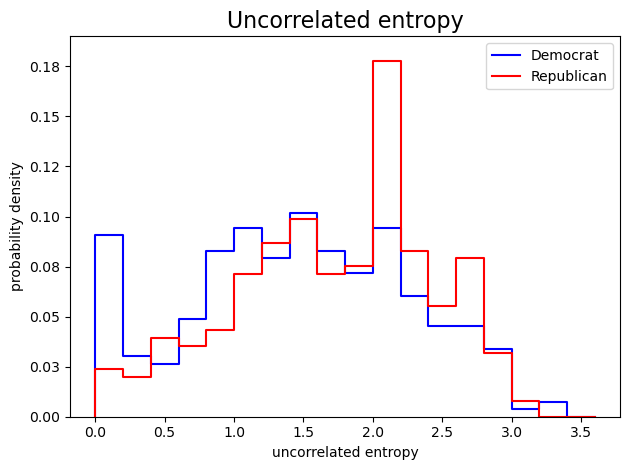

In [127]:
bins = np.append(bins, bins[-1] + (bins[1] - bins[0]))

plt.step(
    bins[:-1],
    values_uncor_d[:-1],
    label="Democrat",
    color="blue",
)

plt.step(
    bins[:-1],
    values_uncor_r[:-1],
    label="Republican",
    color="red",
)

plt.title("Uncorrelated entropy", fontsize=16)
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.ylim(0,0.19)
plt.legend()

import matplotlib.ticker as ticker

plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))


plt.tight_layout()

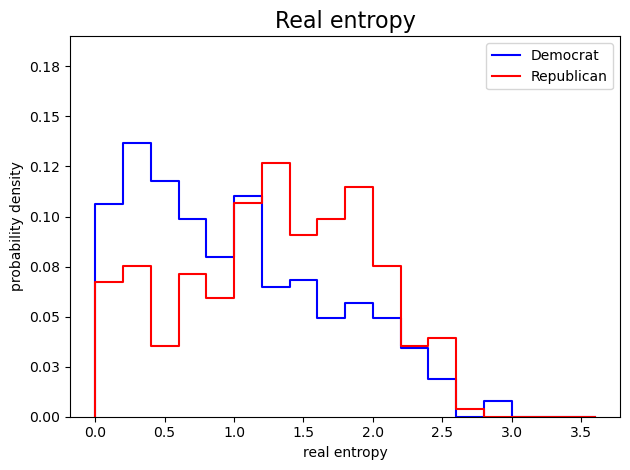

In [133]:
bins = np.append(bins, bins[-1] + (bins[1] - bins[0]))

plt.step(
    bins[:-1],
    values_real_d[:-1],
    label="Democrat",
    color="blue",
)

plt.step(
    bins[:-1],
    values_real_r[:-1],
    label="Republican",
    color="red",
)

plt.title("Real entropy", fontsize=16)
plt.ylabel("probability density")
plt.xlabel("real entropy")
plt.legend()
plt.ylim(0, 0.19)

# keep only two decimal numbers
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))


plt.tight_layout()

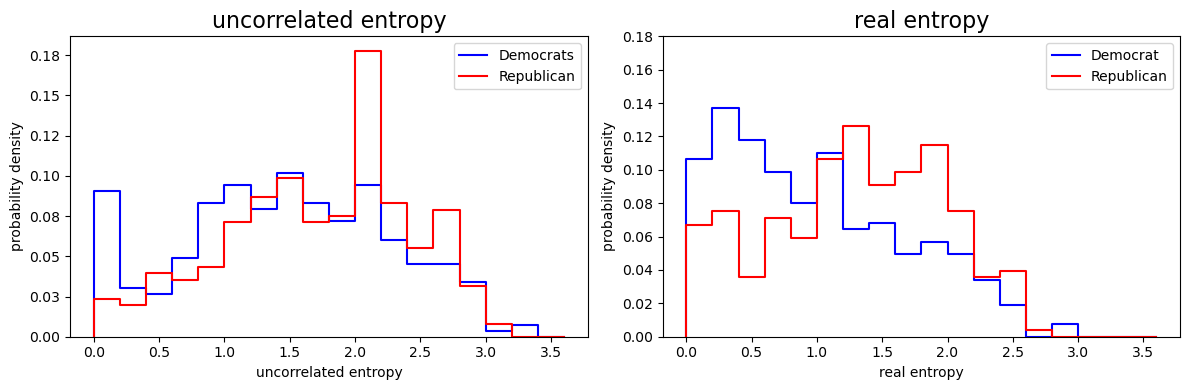

In [8]:
# two plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

bins = np.append(bins, bins[-1] + (bins[1] - bins[0]))

axes[0].step(
    bins[:-1],
    values_uncor_d[:-1],
    label="Democrats",
    color="blue",
)

axes[0].step(
    bins[:-1],
    values_uncor_r[:-1],
    label="Republican",
    color="red",
)


axes[0].set_title("uncorrelated entropy", fontsize=16)
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(bottom=0)
axes[0].legend()

axes[1].step(
    bins[:-1],
    values_real_d[:-1],
    label="Democrat",
    color="blue",
)

axes[1].step(
    bins[:-1],
    values_real_r[:-1],
    label="Republican",
    color="red",
)

axes[1].set_title("real entropy", fontsize=16)
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("real entropy")
axes[1].set_ylim(bottom=0)
axes[1].legend()
axes[1].set_ylim(0, 0.18)


# keep only two decimal numbers
axes[0].yaxis.set_major_formatter(formatter)
axes[1].yaxis.set_major_formatter(formatter)


plt.tight_layout()

## Visuals for report

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_37735/3186951701.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data["ad_creation_time"] = pd.to_datetime(user_data["ad_creation_time"])


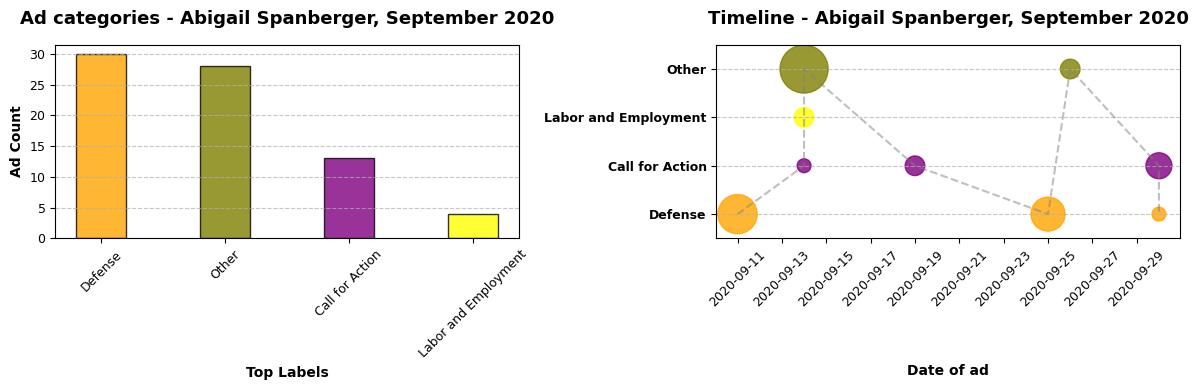

In [303]:
col = {
    "Call for Action": "purple",
    "Defense": "orange",
    "Labor and Employment": "yellow",
    "Other": "olive",
}

user_data = data[data["page_id"] == 485980975070908]
user_data["ad_creation_time"] = pd.to_datetime(user_data["ad_creation_time"])

user_data = user_data[
    (user_data["ad_creation_time"].dt.year == 2020)
    & (user_data["ad_creation_time"].dt.month == 9)
]

# Sort data by time
user_data = user_data.sort_values(by="ad_creation_time")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

label_counts = user_data["top_label"].value_counts()

axes[0].bar(
    label_counts.index,
    label_counts.values,
    color=[col[label] for label in label_counts.index],
    edgecolor="black",
    alpha=0.8,
    width=0.4
)


axes[0].set_title(
    "Ad categories - Abigail Spanberger, September 2020",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
axes[0].set_ylabel("Ad Count", fontweight="bold",fontsize=10)
axes[0].set_xlabel("Top Labels", fontweight="bold", fontsize=10)

# Add gridlines
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Customize ticks
axes[0].tick_params(axis="x", rotation=45, labelsize=9)
axes[0].tick_params(axis="y", labelsize=9)

if not user_data.empty:
    # Group by date and category to count occurrences
    grouped_data = (
        user_data.groupby(["ad_creation_time", "top_label"])
        .size()
        .reset_index(name="count")
    )

    # Extract trajectory and times
    trajectory = grouped_data["top_label"].tolist()
    dates = grouped_data["ad_creation_time"].tolist()
    sizes = grouped_data["count"].tolist()  # Use counts as dot sizes

    # Map categories to a numeric y-axis
    categories = list(grouped_data["top_label"].unique())
    category_map = {category: i for i, category in enumerate(categories)}

    # Convert categories to numeric positions
    y_positions = [category_map[cat] for cat in trajectory]

    # Map colors to points
    point_colors = [col[label] for label in trajectory]

    # Plot each point with size based on count
    axes[1].scatter(
        dates,
        y_positions,
        s=[size * 50 for size in sizes],
        alpha=0.8,
        color=point_colors,
    )
    axes[1].plot(dates, y_positions, color="gray", linestyle="--", alpha=0.5)
    axes[1].set_title(
        "Timeline - Abigail Spanberger, September 2020",
        fontsize=13,
        fontweight="bold",
        pad=15,
    )
    axes[1].set_xlabel("Date of ad", fontweight="bold", fontsize=10, labelpad=40)
    # axes[1].set_ylabel("Ad Categories", fontsize=8, labelpad=10)
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)

    # Format x-axis ticks
    axes[1].tick_params(axis="x", rotation=45, labelsize=9)
    axes[1].set_yticks(range(len(categories)))
    axes[1].set_yticklabels(categories, fontweight="bold", fontsize=9)
    axes[1].set_ylim(-0.5, len(categories) - 0.5)

# Ensure tight layout for the subplots
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.tight_layout()
plt.show()

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_37735/2009223942.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data["ad_creation_time"] = pd.to_datetime(user_data["ad_creation_time"])


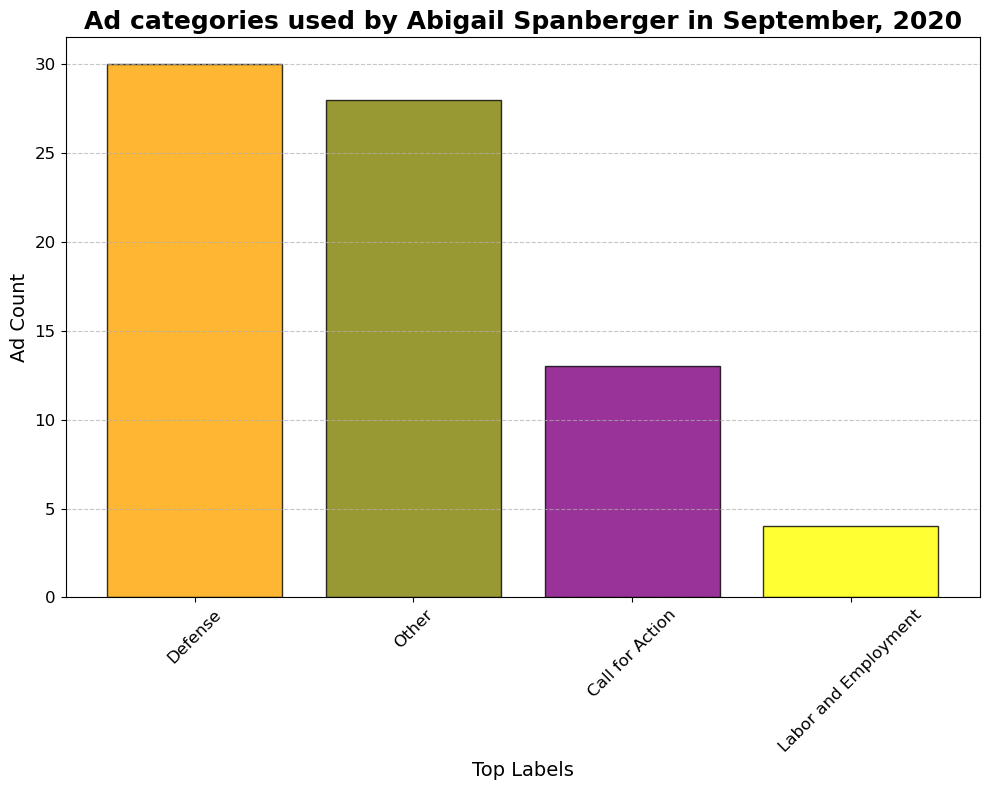

In [239]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 3: Create a timeline plot
plt.figure(figsize=(10, 8))

user_data = data[data["page_id"] == 485980975070908]

# Define colors for each category
col = {
    "Call for Action": "purple",
    "Defense": "orange",
    "Labor and Employment": "yellow",
    "Other": "olive",
 }

user_data["ad_creation_time"] = pd.to_datetime(user_data["ad_creation_time"])

user_data = user_data[
    (user_data["ad_creation_time"].dt.year == 2020)
    & (user_data["ad_creation_time"].dt.month == 9)
]
# Create a count for each category
label_counts = user_data["top_label"].value_counts()

# Plot the histogram using bar chart style for discrete categories
bars = plt.bar(
    label_counts.index,
    label_counts.values,
    color=[col[label] for label in label_counts.index],
    edgecolor="black",
    alpha=0.8,
)

# Add labels and title
plt.title(f"Ad categories used by Abigail Spanberger in September, 2020", fontsize=18, fontweight="bold")
plt.ylabel("Ad Count", fontsize=14)
plt.xlabel("Top Labels", fontsize=14)

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Customize ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_37735/3452347339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data["ad_creation_time"] = pd.to_datetime(user_data["ad_creation_time"])


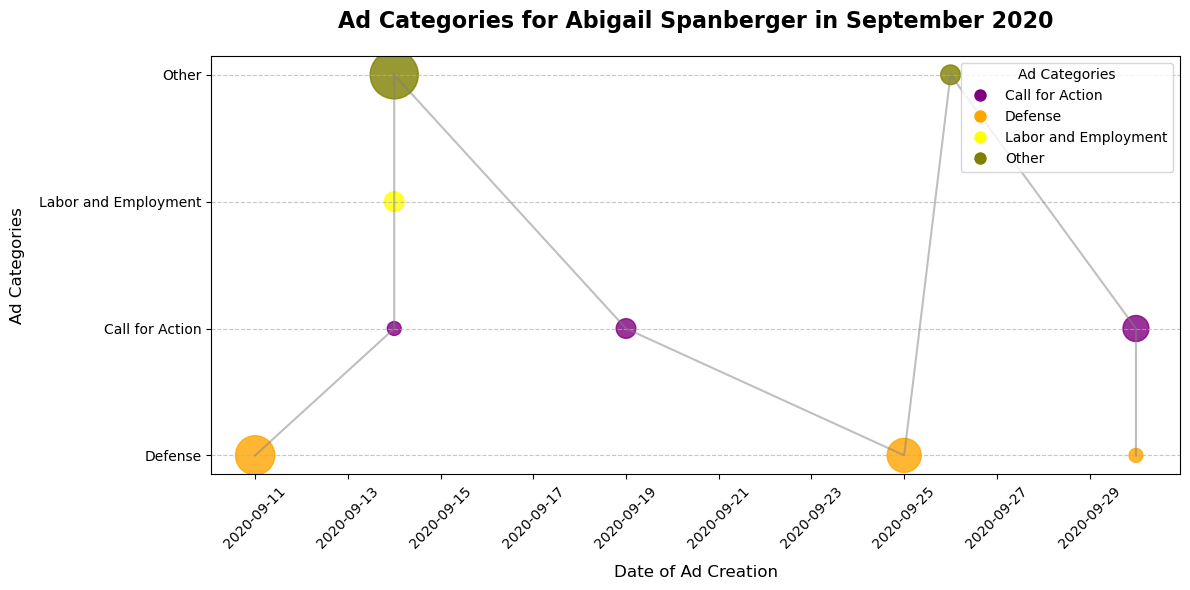

In [260]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D


# Ensure ad_creation_time is datetime and clean missing values
user_data = data[data["page_id"] == 485980975070908]
user_data["ad_creation_time"] = pd.to_datetime(user_data["ad_creation_time"])

# Filter data for a specific month (e.g., September 2018)
user_data = user_data[
    (user_data["ad_creation_time"].dt.year == 2020)
    & (user_data["ad_creation_time"].dt.month == 9)
]

# Sort data by time
user_data = user_data.sort_values(by="ad_creation_time")

point_colors = [col[label] for label in trajectory]

# Ensure there's data to plot
if user_data.empty:
    print("No data available for the specified month.")
else:
    # Group by date and category to count occurrences
    grouped_data = (
        user_data.groupby(["ad_creation_time", "top_label"])
        .size()
        .reset_index(name="count")
    )

    # Extract trajectory and times
    trajectory = grouped_data["top_label"].tolist()
    dates = grouped_data["ad_creation_time"].tolist()
    sizes = grouped_data["count"].tolist()  # Use counts as dot sizes

    # Map categories to a numeric y-axis
    categories = list(grouped_data["top_label"].unique())
    category_map = {category: i for i, category in enumerate(categories)}

    # Convert categories to numeric positions
    y_positions = [category_map[cat] for cat in trajectory]

    # Plot the timeline
    plt.figure(figsize=(12, 6))

    # Plot each point with size based on count
    plt.scatter(
        dates,
        y_positions,
        s=[size * 50 for size in sizes],
        alpha=0.8,
        color=point_colors,
    )
    plt.plot(
        dates, y_positions, color="gray", linestyle="-", alpha=0.5
    )  # Optional line

    legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=label,
        markersize=10,
        markerfacecolor=col[label],
    )
    for label in col.keys()]
    plt.legend(handles=legend_elements, title="Ad Categories", loc="upper right")

    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(range(len(categories)), categories, fontsize=10)

    plt.title(
    "Ad Categories for Abigail Spanberger in September 2020",
    fontsize=16,
    fontweight="bold",
    pad=20,
    )
    plt.xlabel("Date of Ad Creation", fontsize=12, labelpad=10)
    plt.ylabel("Ad Categories", fontsize=12, labelpad=10)
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

## Threshold plots

In [36]:
threshold_2 = data[
    data["top_score"] >= 0.2
]  # from 459.728 to 457.609  # 517 politicians (1 is filtered away)
threshold_4 = data[
    data["top_score"] >= 0.4
]  # from 459.728 to 442.854  # 516 politicians (2 is filtered away)

In [216]:
values_uncor_2, bins = np.histogram(
    data_un["uncor entropy >=2"], bins=bins
)
values_uncor_2 = values_uncor_2 / sum(values_uncor_2)

values_uncor_4, bins = np.histogram(data_un["uncor entropy >=4"], bins=bins)
values_uncor_4 = values_uncor_4 / sum(values_uncor_4)

###################################################################################

values_real_2, bins = np.histogram(
    data_un["real entropy >=2"], bins=bins
)
values_real_2 = values_real_2 / sum(values_real_2)

values_real_4, bins = np.histogram(data_un["real_entropy >=4"], bins=bins)
values_real_4 = values_real_4 / sum(values_real_4)

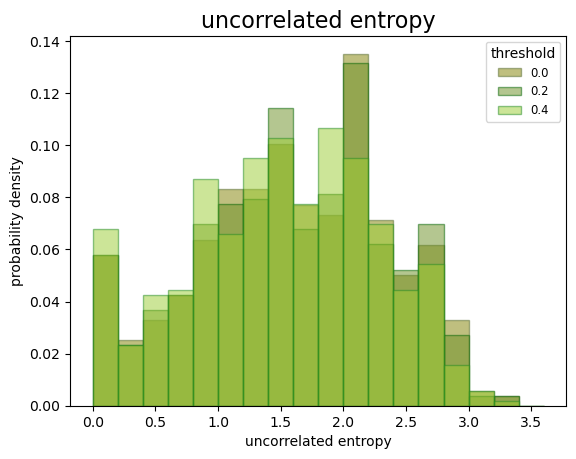

In [113]:
plt.bar(
    bins[:-1],
    values_uncor,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

plt.bar(
    bins[:-1],
    values_uncor_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

plt.bar(
    bins[:-1],
    values_uncor_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

plt.title("uncorrelated entropy", fontsize=16)
#plt.legend()
legend = plt.legend( fontsize="small", fancybox=True)
legend.set_title("threshold")
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()

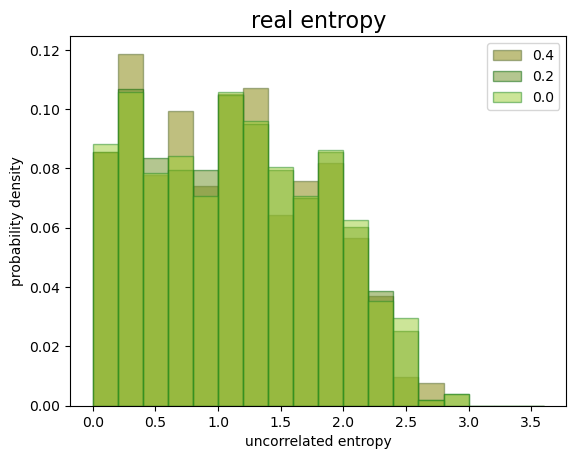

In [64]:
plt.bar(
    bins[:-1],
    values_real_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

plt.bar(
    bins[:-1],
    values_real_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

plt.bar(
    bins[:-1],
    values_real,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

plt.title("real entropy", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()

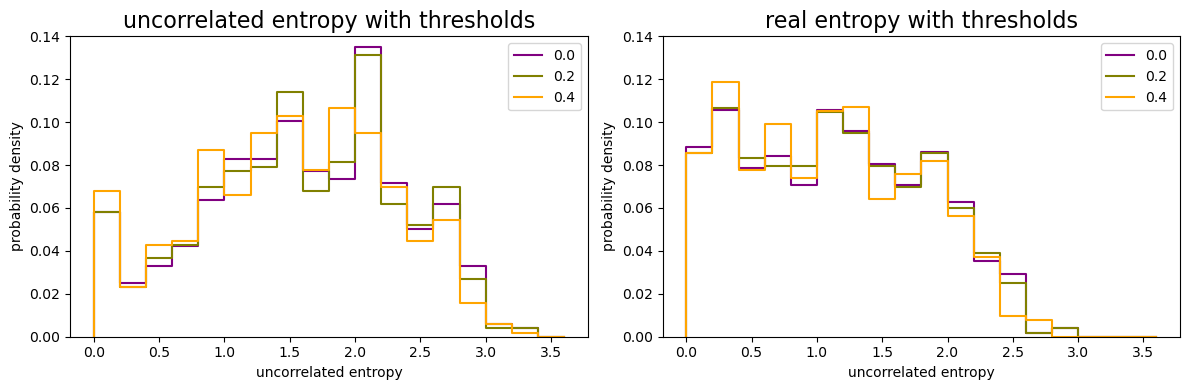

In [215]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Insert 0 at the start of the data arrays
values_real_0 = np.insert(values_real, 0, 0)
values_real_0 = np.append(values_real_0, 0)

values_real_2_0 = np.insert(values_real_2, 0, 0)
values_real_2_0 = np.append(values_real_2_0, 0)

values_real_4_0 = np.insert(values_real_4, 0, 0)
values_real_4_0 = np.append(values_real_4_0, 0)


values_uncor_0 = np.insert(values_uncor, 0, 0)
values_uncor_0 = np.append(values_uncor_0, 0)

values_uncor_2_0 = np.insert(values_uncor_2, 0, 0)
values_uncor_2_0 = np.append(values_uncor_2_0, 0)

values_uncor_4_0 = np.insert(values_uncor_4, 0, 0)
values_uncor_4_0 = np.append(values_uncor_4_0, 0)

bins = np.append(bins, bins[-1] + (bins[1] - bins[0]))


# Plot on the first subplot (axes[0])
axes[0].step(
    bins[:-1],
    values_uncor_0[:-1],  # Slice values_real_4_0 to match bins[:-1]
    label="0.0",
    color="purple",
)

axes[0].step(
    bins[:-1],
    values_uncor_2_0[:-1],  # Slice values_real_2_0 to match bins[:-1]
    label="0.2",
    color="olive",
)

axes[0].step(
    bins[:-1],
    values_uncor_4_0[:-1],  # Slice values_real_0 to match bins[:-1]
    label="0.4",
    color="orange",
)

axes[0].set_title("uncorrelated entropy with thresholds", fontsize=16)
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(0, 0.14)
axes[0].legend()

axes[1].step(
    bins[:-1],
    values_real_0[:-1],  # Slice values_real_4_0 to match bins[:-1]
    label="0.0",
    color="purple",
)

axes[1].step(
    bins[:-1],
    values_real_2_0[:-1],  # Slice values_real_2_0 to match bins[:-1]
    label="0.2",
    color="olive",
)

axes[1].step(
    bins[:-1],
    values_real_4_0[:-1],  # Slice values_real_0 to match bins[:-1]
    label="0.4",
    color="orange",
)

# Set the title, labels, and legend for the first subplot
axes[1].set_title("real entropy with thresholds", fontsize=16)
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].set_ylim(0, 0.14)
axes[1].legend()

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()

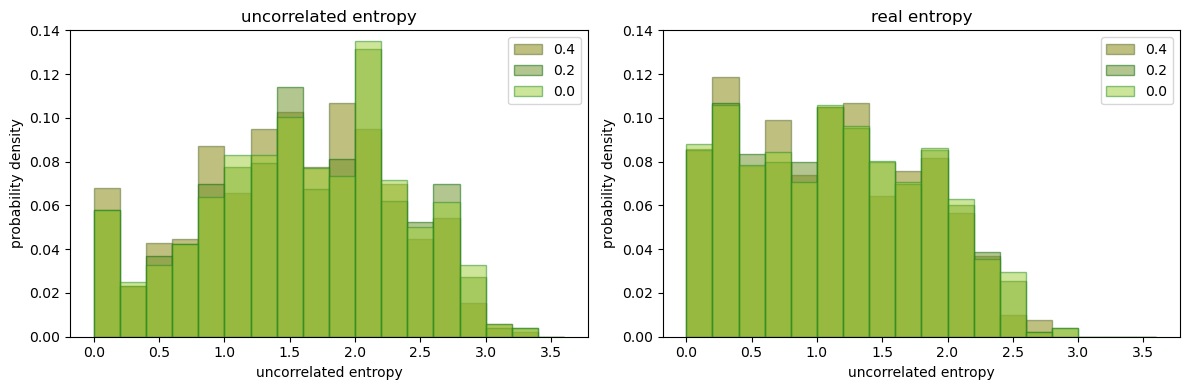

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_uncor_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)
axes[0].bar(
    bins[:-1],
    values_uncor_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

axes[0].bar(
    bins[:-1],
    values_uncor,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

axes[0].set_title("uncorrelated entropy")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(0, 0.14)
axes[0].legend()

axes[1].bar(
    bins[:-1],
    values_real_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)
axes[1].bar(
    bins[:-1],
    values_real_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

axes[1].bar(
    bins[:-1],
    values_real,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)
axes[1].set_title("real entropy")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].set_ylim(0, 0.14)
axes[1].legend()

plt.tight_layout()
plt.show()

In [230]:
values_uncor_d_th2, bins = np.histogram(df1["uncor entropy >=2"], bins=bins)
values_uncor_d_th2 = values_uncor_d_th2 / sum(values_uncor_d_th2)

values_uncor_d_th4, bins = np.histogram(df1["uncor entropy >=4"], bins=bins)
values_uncor_d_th4 = values_uncor_d_th4 / sum(values_uncor_d_th4)

values_uncor_r_th2, bins = np.histogram(df2["uncor entropy >=2"], bins=bins)
values_uncor_r_th2 = values_uncor_r_th2 / sum(values_uncor_r_th2)

values_uncor_r_th4, bins = np.histogram(df2["uncor entropy >=4"], bins=bins)
values_uncor_r_th4 = values_uncor_r_th4 / sum(values_uncor_r_th4)

#########################################################################################

values_real_d_th2, bins = np.histogram(df1["real entropy >=2"], bins=bins)
values_real_d_th2 = values_real_d_th2 / sum(values_real_d_th2)

values_real_d_th4, bins = np.histogram(df1["real_entropy >=4"], bins=bins)
values_real_d_th4 = values_real_d_th4 / sum(values_real_d_th4)

values_real_r_th2, bins = np.histogram(df2["real entropy >=2"], bins=bins)
values_real_r_th2 = values_real_r_th2 / sum(values_real_r_th2)

values_real_r_th4, bins = np.histogram(df2["real_entropy >=4"], bins=bins)
values_real_r_th4 = values_real_r_th4 / sum(values_real_r_th4)

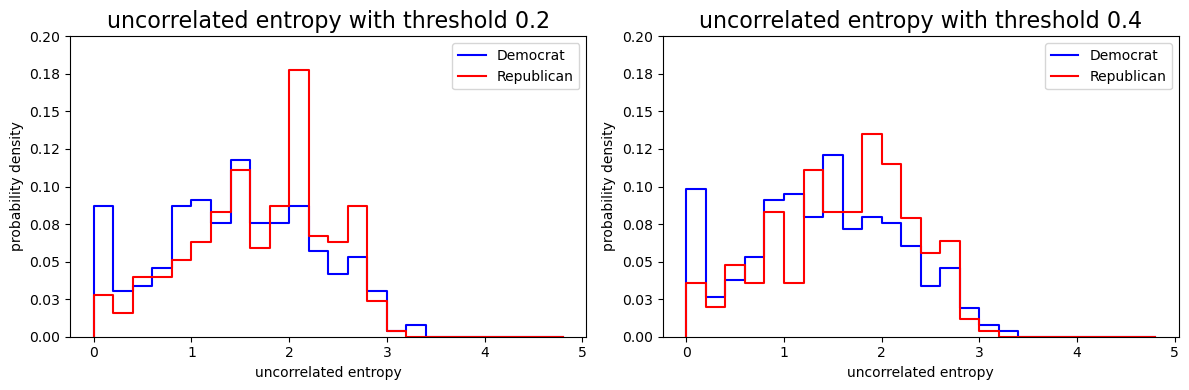

In [229]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Insert 0 at the start of the data arrays
values_uncor_d_th2 = np.insert(values_uncor_d_th2, 0, 0)
values_uncor_d_th2 = np.append(values_uncor_d_th2, 0)

values_uncor_r_th2 = np.insert(values_uncor_r_th2, 0, 0)
values_uncor_r_th2 = np.append(values_uncor_r_th2, 0)


values_uncor_d_th4 = np.insert(values_uncor_d_th4, 0, 0)
values_uncor_d_th4 = np.append(values_uncor_d_th4, 0)

values_uncor_r_th4 = np.insert(values_uncor_r_th4, 0, 0)
values_uncor_r_th4 = np.append(values_uncor_r_th4, 0)

bins = np.append(bins, bins[-1] + (bins[1] - bins[0]))
# Plot on the first subplot (axes[0])
axes[0].step(
    bins[:-1],
    values_uncor_d_th2[:-1],  # Slice values_real_4_0 to match bins[:-1]
    label="Democrat",
    color="blue",
)

axes[0].step(
    bins[:-1],
    values_uncor_r_th2[:-1],  # Slice values_real_2_0 to match bins[:-1]
    label="Republican",
    color="red",
)


axes[0].set_title("uncorrelated entropy with threshold 0.2", fontsize=16)
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(bottom=0)
axes[0].legend()

axes[1].step(
    bins[:-1],
    values_uncor_d_th4[:-1],  # Slice values_real_4_0 to match bins[:-1]
    label="Democrat",
    color="blue",
)

axes[1].step(
    bins[:-1],
    values_uncor_r_th4[:-1],  # Slice values_real_2_0 to match bins[:-1]
    label="Republican",
    color="red",
)


# Set the title, labels, and legend for the first subplot
axes[1].set_title("uncorrelated entropy with threshold 0.4", fontsize=16)
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].legend()
axes[0].set_ylim(0, 0.20)
axes[1].set_ylim(0, 0.20)

axes[0].yaxis.set_major_formatter(formatter)
axes[1].yaxis.set_major_formatter(formatter)

plt.tight_layout()

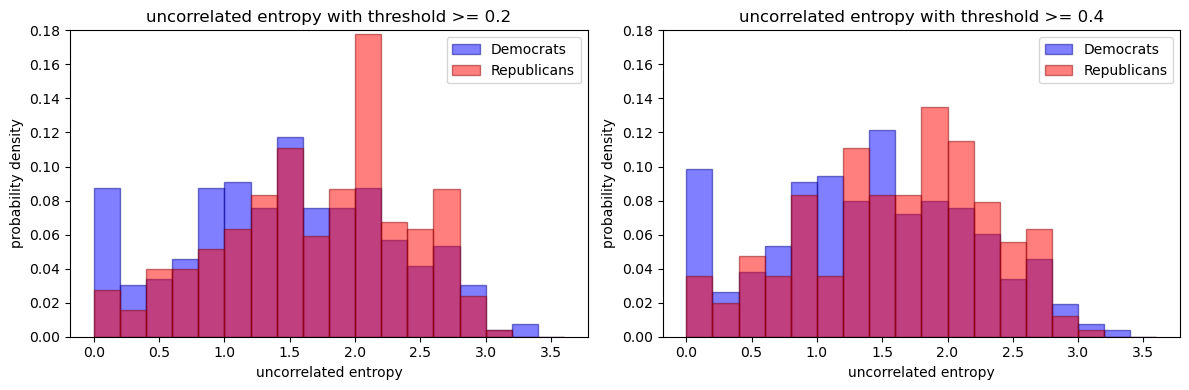

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_uncor_d_th2,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)

axes[0].bar(
    bins[:-1],
    values_uncor_r_th2,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=0.5,
    edgecolor="darkred",
)
axes[0].set_title("uncorrelated entropy with threshold >= 0.2")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].legend()


axes[1].bar(
    bins[:-1],
    values_uncor_d_th4,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    color="blue",
    alpha=0.5,
    edgecolor="darkblue",
)

axes[1].bar(
    bins[:-1],
    values_uncor_r_th4,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=0.5,
    edgecolor="darkred",
)
axes[1].set_title("uncorrelated entropy with threshold >= 0.4")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].set_ylim(0, 0.18)
axes[0].set_ylim(0, 0.18)

axes[1].legend()


plt.tight_layout()
plt.show()

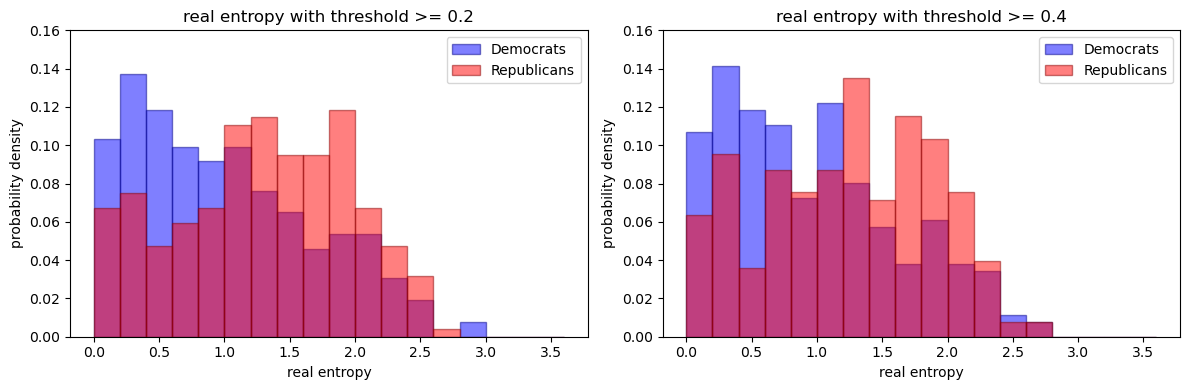

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_real_d_th2,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)

axes[0].bar(
    bins[:-1],
    values_real_r_th2,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=0.5,
    edgecolor="darkred",
)
axes[0].set_title("real entropy with threshold >= 0.2")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("real entropy")

axes[1].bar(
    bins[:-1],
    values_real_d_th4,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    color="blue",
    alpha=0.5,
    edgecolor="darkblue",
)

axes[1].bar(
    bins[:-1],
    values_real_r_th4,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=0.5,
    edgecolor="darkred",
)
axes[1].set_title("real entropy with threshold >= 0.4")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("real entropy")
axes[0].set_ylim(0, 0.16)
axes[1].set_ylim(0, 0.16)
axes[1].legend()
axes[0].legend()


plt.tight_layout()
plt.show()

## special case for calculating real-entropy for Sanders and Ocasio-Cortez

In [ ]:
data_org = pd.read_csv("labeled_ads.csv", index_col=0)

In [ ]:
filtered_data_a = data_org[data_org["page_id"].isin([1316372698453411])] # Sanders page id
midpoint = len(filtered_data_a) // 2

# Split the DataFrame into two parts
df_part1 = filtered_data_a.iloc[:midpoint]
df_part2 = filtered_data_a.iloc[midpoint:]

df_part1["page_id"] = df_part1["page_id"].replace(1316372698453411, 130000000000000)
df_part2["page_id"] = df_part2["page_id"].replace(1316372698453411, 130000000000001)

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_1677/3447034453.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part1["page_id"] = df_part1["page_id"].replace(1316372698453411, 130000000000000)
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_1677/3447034453.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part2["page_id"] = df_part2["page_id"].replace(1316372698453411, 130000000000001)


In [ ]:
filtered_data_b = data_org[
    data_org["page_id"].isin([124955570892789])
]  # Ocasio-Cortez
midpoint = len(filtered_data_b) // 2

# Split the DataFrame into two parts
df_part1_b = filtered_data_b.iloc[:midpoint]
df_part2_b = filtered_data_b.iloc[midpoint:]

df_part1_b["page_id"] = df_part1_b["page_id"].replace(124955570892789, 120000000000000)
df_part2_b["page_id"] = df_part2_b["page_id"].replace(124955570892789, 120000000000001)

In [ ]:
## Archive

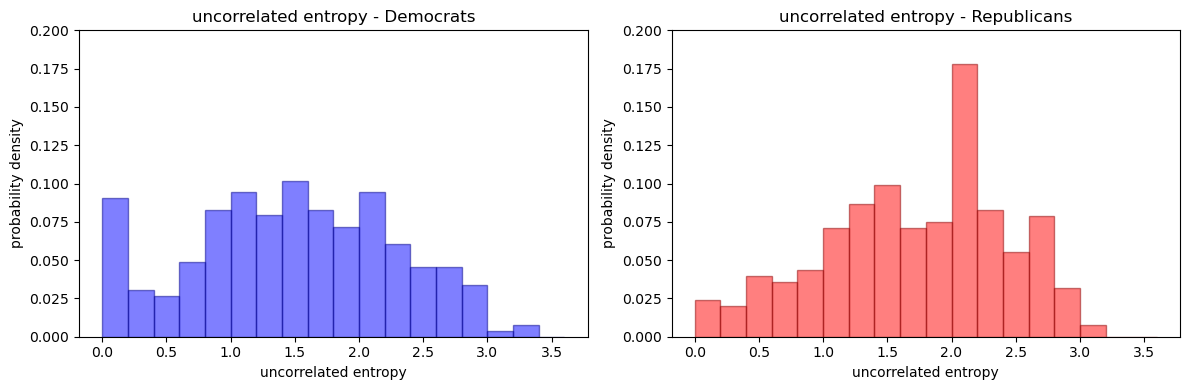

In [ ]:
df1 = data_un[data_un["party"] == "Democrat"]
df2 = data_un[data_un["party"] == "Republican"]

values_uncor_d, bins = np.histogram(
    df1["uncor entropy"], bins=np.linspace(0, 3.6, 19)
)
values_uncor_d = values_uncor_d / sum(values_uncor_d)

# Calculate and normalize values for real entropy
values_uncor_r, bins = np.histogram(
    df2["uncor entropy"], bins=bins
)
values_uncor_r = values_uncor_r / sum(values_uncor_r)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_uncor_d,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)
axes[0].set_title("uncorrelated entropy - Democrats")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")

axes[1].bar(
    bins[:-1],
    values_uncor_r,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="red",
    edgecolor="darkred",
)

max_y = max(max(values_uncor_r), max(values_uncor_d))
y_limit = round(max_y + 0.05, 2)

axes[1].set_title("uncorrelated entropy - Republicans")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(0, 0.2)
axes[1].set_ylim(0, 0.2)

plt.tight_layout()
plt.show()

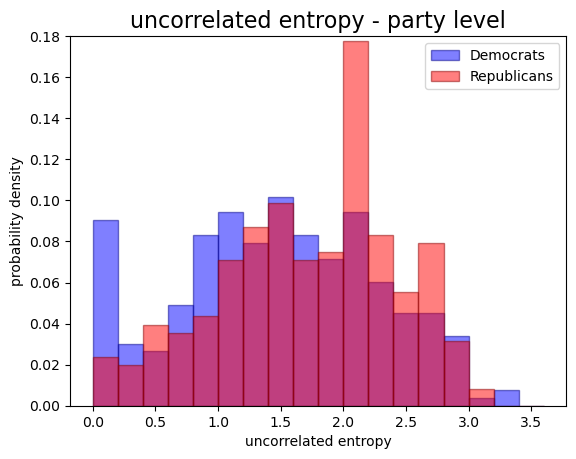

In [ ]:
plt.bar(
    bins[:-1],
    values_uncor_d, 
    align='edge',
    width=bins[1] - bins[0],
    label="Democrats",
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)

plt.bar(
    bins[:-1],
    values_uncor_r,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=.5,
    edgecolor="darkred",
)

plt.title("uncorrelated entropy - party level", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.ylim(0, 0.18) 
plt.show()

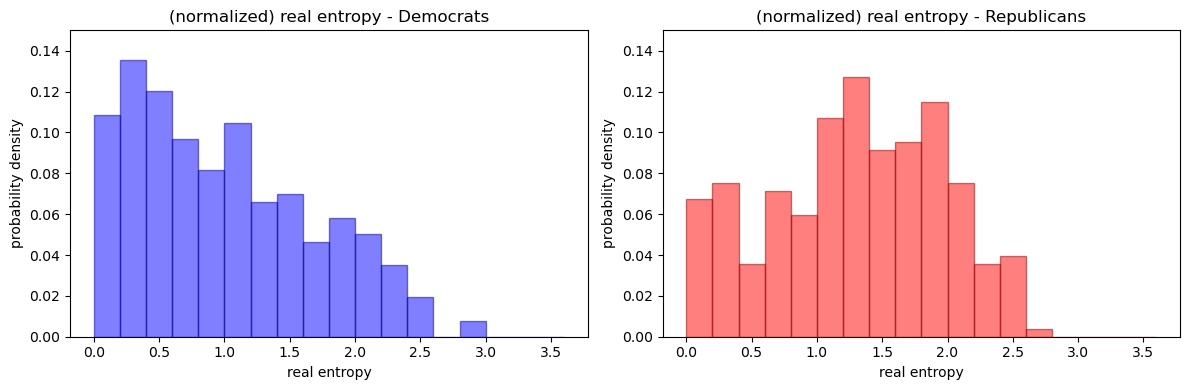

In [191]:
values_real_d, bins = np.histogram(df1["real entropy"], bins=np.linspace(0, 3.6, 19))
values_real_d = values_real_d / sum(values_real_d)

# Calculate and normalize values for real entropy
values_real_r, bins = np.histogram(df2["real entropy"], bins=bins)
values_real_r = values_real_r / sum(values_real_r)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_real_d,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)
axes[0].set_title("(normalized) real entropy - Democrats")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("real entropy")

axes[1].bar(
    bins[:-1],
    values_real_r,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="red",
    edgecolor="darkred",
)


axes[1].set_title("(normalized) real entropy - Republicans")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("real entropy")
axes[0].set_ylim(0, 0.15)
axes[1].set_ylim(0, 0.15)

plt.tight_layout()
plt.show()

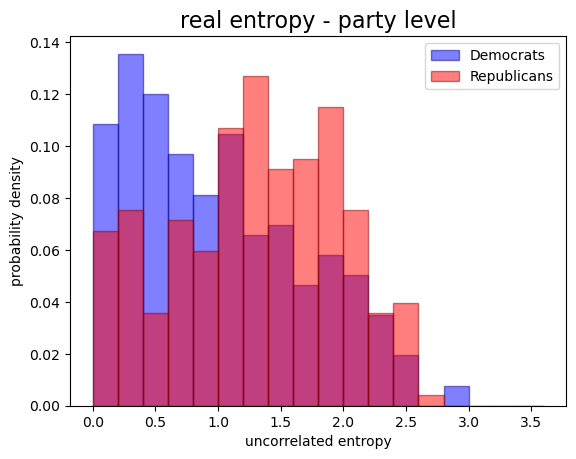

In [190]:
plt.bar(
    bins[:-1],
    values_real_d,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)

plt.bar(
    bins[:-1],
    values_real_r,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    alpha=0.5,
    color="red",
    edgecolor="darkred",
)

plt.title("real entropy - party level", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()

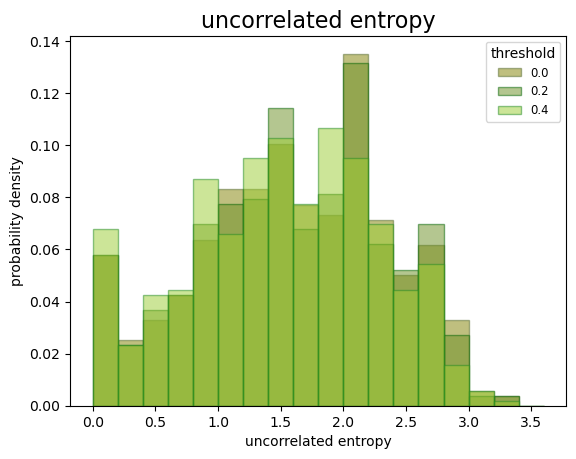

In [ ]:
plt.bar(
    bins[:-1],
    values_uncor,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

plt.bar(
    bins[:-1],
    values_uncor_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

plt.bar(
    bins[:-1],
    values_uncor_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

plt.title("uncorrelated entropy", fontsize=16)
#plt.legend()
legend = plt.legend( fontsize="small", fancybox=True)
legend.set_title("threshold")
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()

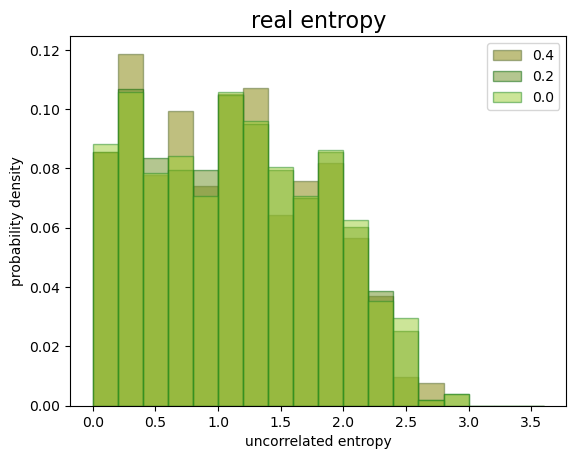

In [ ]:
plt.bar(
    bins[:-1],
    values_real_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

plt.bar(
    bins[:-1],
    values_real_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

plt.bar(
    bins[:-1],
    values_real,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

plt.title("real entropy", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()